# Preprocessing peptide identifications to be compiled into a training set
This notebook demonstrates how one can make use of `ionmob` to extract peptide identifications from a peptide identification list. It uses output generated by `PEAKS` [software](https://www.bioinfor.com/peaks-studio/). Files are not contained in this repository but are available trough [PRIDE](https://www.ebi.ac.uk/pride/). The small pipeline contains the following steps:

1. Read the data and create scalar inverse ion-mobilities.
2. Translate inverse ion-mobilities into CCS values using the [Mason Schamp equation](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/full/10.1002/mas.21585) for low field mobility separation.
3. Tokenize sequences into a standardized format for downstream training or transfer learning of a new or existing predictor of CCS.
4. Align CCS values (*optional*) to a reference file, this assumes that you want to generate a extensive corpus of training data potentially comming from different data sources.
5. Identify Peptides with identical sequence and charge that occur with significantly different CCS values (*so-called mulit-modal features*) and remove the lower abundant species(*optional*), this is necesarry to avoid bad perdictor performance for models trained using and EM strategy.
6. Make the occurences of sequence and charge pairs in a given dataset unique, thus preventing a class bias towords highly abundant peptides.

In [1]:
import os
# suppress CUDA logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from ionmob.data.chemistry import reduced_mobility_to_ccs
from ionmob.preprocess.helpers import preprocess_peaks_sequence
from ionmob.preprocess.helpers import get_ccs_shift, apply_shift_per_charge

## 1. - 3. Read identification files, calculate inverse ion-mobility and CCS, tokenize

In [2]:
# we read a PEAKS DB search result file to start getting training data ready
peaks_data = pd.read_csv('../../notebook/data/phospho/PHOS_NEW/PEAKS_Phospho/SCP_FDR001/2022-152_Phospho_HeLa_F220819_UD_DG_PEAKS_14/DB search psm.csv')

# for convenience, rename a few columns to be more descriptive
peaks_data = peaks_data[['m/z', 'Z', 'Peptide', '1/k0 Range', 'RT', 'Area']].rename(
    columns={'m/z': 'mz', 'Z': 'charge', 'RT': 'rt', 'Area': 'intensity'})

# for now, ionmob predictors only include charges from 1-4
peaks_data = peaks_data[peaks_data.charge < 5]

# PEAKS does not provide a scalar 1/K0 value, we therefore need to calculate it to be the mid-point between
# PEAKS reported start and end of the inverse ion-mobility distribution of a given peptide
# This assumes 1/K0 to be normally distributed, which is a good approximation to find the distribution APEX
peaks_data['1/k0'] = peaks_data.apply(lambda r: np.mean(np.array([float(r['1/k0 Range'].split('-')[0]), 
                                          float(r['1/k0 Range'].split('-')[1])])), axis=1)

# next, CCS values need to be calculated from 1/K0 using the MASON SCHAMP equation:
# CCS -> F(1/K0, mz, z)
peaks_data['ccs'] = reduced_mobility_to_ccs(peaks_data['1/k0'], peaks_data['mz'], peaks_data['charge'])

# Peptide sequences are tokenized, providing a unified vocabulary for the following alignment step
peaks_data['sequence-tokenized'] = peaks_data.apply(lambda r: preprocess_peaks_sequence(r['Peptide']), axis=1)
peaks_data['name'] = ex_name = "descriptive-name"

## 4. Align to reference data

In [3]:
# read some refference data, containing your initial training corpus
data_meier = pd.read_parquet('../../notebook/data/unimod/Meier_unimod.parquet')

In [4]:
# calculate a mean shift of CCS values, prevents high systematic error
mean = get_ccs_shift(peaks_data, data_meier)
peaks_data['ccs_shifted'] = peaks_data['ccs'] + mean

In [5]:
# remove duplicates of Peptide, charge and CCS
peaks_data = peaks_data.drop_duplicates(['Peptide', 'charge', 'ccs'])
peaks_data['intensity'] = peaks_data['intensity'] + 1.0000001

## 5. Identify and remove multi-modal Peptide occurences

In [6]:
from ionmob.alignment import experiment as exp
from ionmob.alignment import alignment as alig

# create a copy of the dataset
shifted_all = peaks_data.copy()

# extract necessary columns
seq, charge, ccs, intensity, mz, raw_file = shifted_all["Peptide"].values, shifted_all["charge"].values, shifted_all["ccs_shifted"].values, np.ones_like(shifted_all["mz"].values), shifted_all["mz"].values, shifted_all["name"].values

# create an Experiment object from a given identification file used for modality assignment
ex1 = exp.Experiment(
    ex_name, 
    seq, 
    charge, 
    ccs,
    intensity, 
    mz, 
    raw_file, 
    np.arange(shifted_all.shape[0]), 
    shifted_all.rt.values, 
    shifted_all.rt.values, 
    shifted_all.rt.values,
    shifted_all.mz.values
)

# assign modalities to peptides (can take some time to execute)
ex2 = ex1.assign_modalities()

In [7]:
# filter the dataset to only contain unimodal and high-abundant peptide modality classes
grouped = ex2.data[(ex2.data.modality == 'main') | (ex2.data.modality == 'unimodal')]

In [8]:
# last step is to extract the correct CCS values including the alignment by matching the 
# extracted correct modalities with the complete dataset
data_shifted = peaks_data.copy()

# extract the join columns
merge_data = grouped[['sequence', 'charge', 'ccs']]

# merge using sequence and charge as keys
both = pd.merge(left=data_shifted, right=merge_data, left_on=['Peptide', 'charge'], 
                right_on=['sequence', 'charge'])

# extract informative columns, remove duplicates
singletons = both[['mz', 'charge', 'Peptide', 'sequence-tokenized', 'rt', 
                   'name', 'ccs_y']].drop_duplicates(['Peptide', 'charge']).rename(columns={'ccs_y':'ccs'})

# get data for output
s = singletons[['mz', 'charge', 'sequence-tokenized', 'rt', 'name', 'ccs']]

# re-order
processed_data = s[['mz', 'charge', 'sequence-tokenized', 'rt', 'ccs', 'name']]

In [9]:
# write data to a file
# processed_data.to_parquet('out.parquet', index=False)

## 6. Visualize

In [10]:
# generate some data to visualize the shift to be applied to the dataset
peaks_data['join_sequence'] = peaks_data.apply(lambda r: ''.join(list(r['sequence-tokenized'])), axis=1)
data_meier['join_sequence'] = data_meier.apply(lambda r: ''.join(list(r['sequence-tokenized'])), axis=1)
both = pd.merge(left=peaks_data, right=data_meier, left_on=['join_sequence', 'charge'], right_on=['join_sequence', 'charge'])

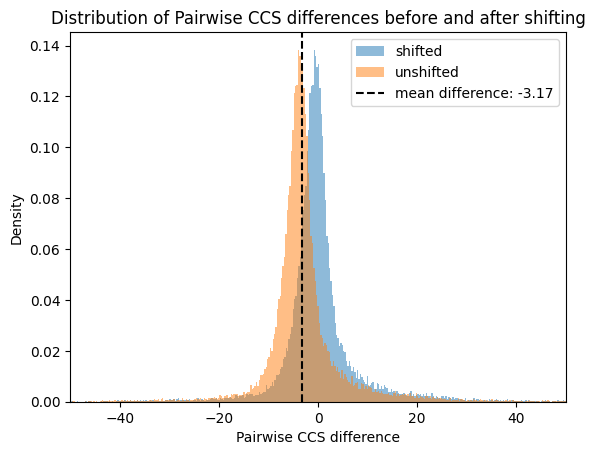

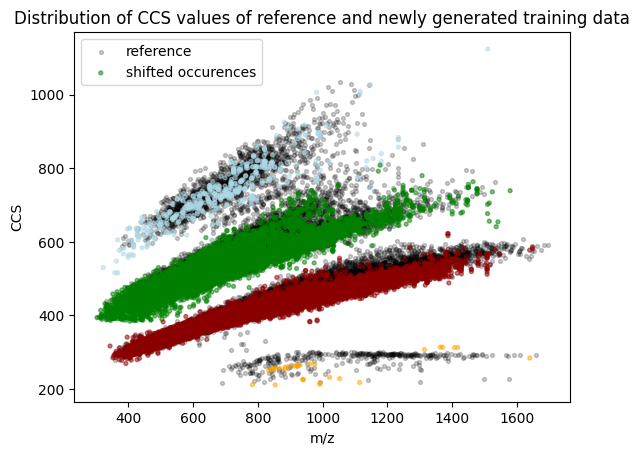

In [11]:
# 
plt.title('Distribution of Pairwise CCS differences before and after shifting')
plt.hist(both.ccs_y - both.ccs_shifted, bins='auto', alpha=.5, density=True, label='shifted')
plt.hist(both.ccs_y - both.ccs_x, bins='auto', alpha=.5, density=True, label='unshifted')
plt.axvline(x=mean, label=f'mean difference: {np.round(mean,2)}', linestyle='dashed', color='black')
plt.xlabel('Pairwise CCS difference')
plt.ylabel('Density')
plt.xlim([-50, 50])
plt.legend()
plt.show()

# A visual inspection of the processed data compared to the reference is highly recomended to catch bugs early
color_dict = {1: 'orange', 2: 'darkred', 3: 'green', 4: 'lightblue'}

# get some reference data at random to compare own data to
ref = data_meier.sample(frac=.05)

plt.title('Distribution of CCS values of reference and newly generated training data')
plt.scatter(ref.mz, ref.ccs, s=8, alpha=.2, c='black', label='reference')

plt.scatter(processed_data.mz, processed_data.ccs, s=8, alpha=.5,
            label='shifted occurences',
            c=[color_dict[x] for x in processed_data.charge])

plt.xlabel('m/z')
plt.ylabel('CCS')
plt.legend()
plt.show()